# Best Models Comparison

Backtesing and comparison of results for three tuned models. Described in chapter 4.8.

Input: single principal component with PCA for 15 indicators + returns

Output: optimal max-shape portfolio with tight restrictions for the next period

In [1]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv1D, Dropout
from keras.regularizers import L2

from sklearn.ensemble import RandomForestRegressor

import os
os.chdir(os.path.expanduser('..'))
from helper_functions import train_and_evaluate_model, run_full_backtesting

In [2]:
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

## Selected best performing models

In [5]:
x_6_months_flatten = data_provider.get_formatted_features(no_months=6, flatten=True)
(x_train_6_months_flatten, y_train, x_val_6_months_flatten, y_val, 
 x_test_6_months_flatten, y_test) = data_provider.train_train_split(x_6_months_flatten, y)

In [6]:
dnn_model = Sequential((
    Input(shape=x_train_6_months_flatten.shape[1:]),
    Dense(64, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(dnn_model, x_train_6_months_flatten, y_train,
                         x_val_6_months_flatten, y_val, 
                         x_test_6_months_flatten, y_test, verbose=False)

Train error: 0.0005136302788741887
Val error: 0.0005678734160028398
Test error: 0.0009940925519913435
Execution time 4.69 seconds


In [7]:
x_7_months = data_provider.get_formatted_features(no_months=7)
(x_train_7_months, y_train, x_val_7_months, y_val, 
 x_test_7_months, y_test) = data_provider.train_train_split(x_7_months, y)

In [8]:
cnn_model = Sequential((
    Input(shape=x_train_7_months.shape[1:]),
    Conv1D(32, 3),
    Flatten(),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(cnn_model, x_train_7_months, y_train,
                         x_val_7_months, y_val, 
                         x_test_7_months, y_test, verbose=False)

Train error: 0.0005576732801273465
Val error: 0.0006091654067859054
Test error: 0.0010121675441041589
Execution time 4.98 seconds


In [9]:
x_9_months_flatten = data_provider.get_formatted_features(no_months=9, flatten=True)
(x_train_9_months_flatten, y_train, _, _,
 x_test_9_months_flatten, y_test) = data_provider.train_train_split(x_9_months_flatten, y, with_val=False)

In [10]:
random_forest = RandomForestRegressor(max_depth=10, max_features='sqrt',
                                      min_samples_leaf=6, min_samples_split=6,
                                      n_estimators=100, bootstrap=True, random_state=42)


random_forest.fit(x_train_9_months_flatten, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, random_state=42)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


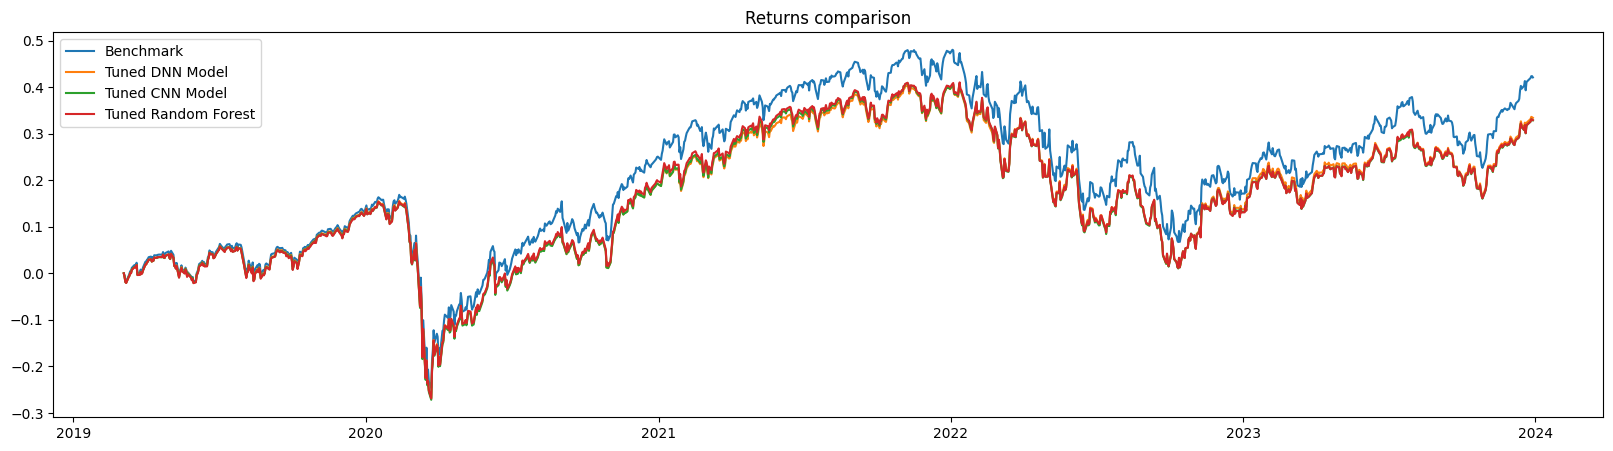

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.0768,0.2033,0.3775,0.4420,-0.3548,500.0,0.2163,0.0000
Tuned DNN Model,0.0623,0.2013,0.3094,0.3580,-0.3667,499.0,0.1698,-0.5447
Tuned CNN Model,0.0614,0.2019,0.3041,0.3526,-0.3684,538.0,0.1667,-0.5633
Tuned Random Forest,0.0615,0.2021,0.3042,0.3534,-0.3662,493.0,0.1679,-0.5850


In [11]:
models_with_data = {
    'Tuned DNN Model': (dnn_model, x_test_6_months_flatten),
    'Tuned CNN Model': (cnn_model, x_test_7_months),
    'Tuned Random Forest': (random_forest, x_test_9_months_flatten)
}

df_results = run_full_backtesting(data_provider, models_with_data)
df_results